In [ ]:
!pip install -r requirements.txt

In [1]:
from decouple import config
import requests
import json
from pathlib import Path
from pymongo import MongoClient
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MultiLabelBinarizer
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import joblib
import plotly.graph_objs as go
import time
from tqdm import tqdm
from multiprocessing import Process, Pool
import multiprocessing 
from pymongo import UpdateOne, InsertOne
from concurrent.futures import ThreadPoolExecutor, as_completed
from itertools import chain
import re
from datetime import datetime
from scipy.stats.mstats import winsorize
from scipy.stats import norm
import warnings
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
from sklearn import metrics
from collections import defaultdict, Counter
import itertools
from deep_translator import GoogleTranslator
import langdetect
from difflib import SequenceMatcher
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import shuffle
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

## Connect to MongoDB

In [29]:
# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['GameDB']
collection = db['Games']
df = pd.DataFrame(list(collection.find()))

## Drop low frequency tags

In [30]:
df.columns

Index(['_id', 'action', 'adventure', 'animation & modeling',
       'audio production', 'casual', 'design & illustration', 'early access',
       'education', 'free to play', 'game development', 'gore', 'indie',
       'mature content', 'mmo', 'nudity', 'photo editing', 'racing',
       'role-playing games', 'simulation', 'software training', 'sports',
       'strategy', 'utilities', 'violent', 'web publishing', 'AppID',
       'Net Votes', 'Peak CCU'],
      dtype='object')

## Filter dataset

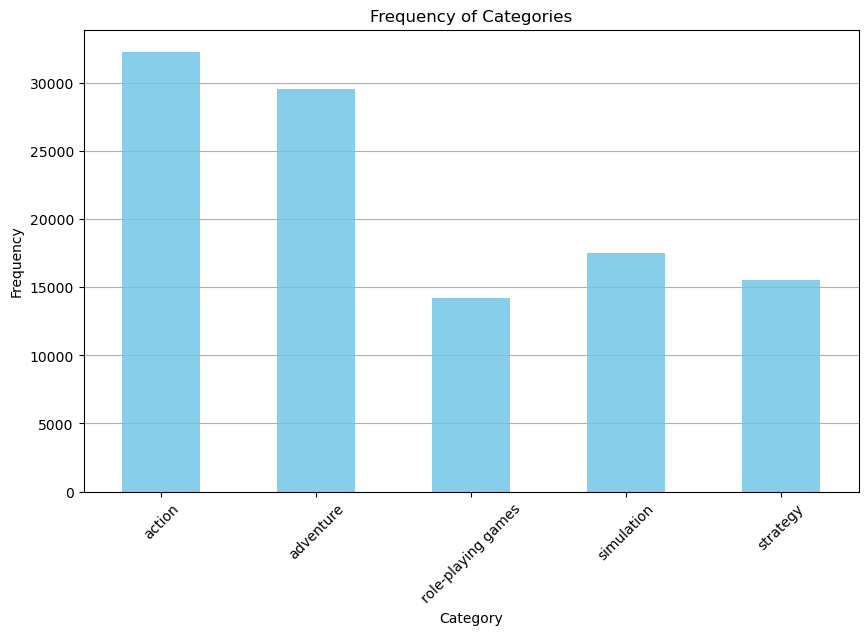

In [33]:
df_temp = df.copy()
df_temp = df_temp.drop(["_id","Net Votes","mmo","racing","sports",'Peak CCU','software training','animation & modeling','audio production', 'casual', 'design & illustration', 'early access','education', 'free to play', 'game development', 'gore', 'indie','mature content', 'nudity', 'photo editing','software training','utilities', 'violent', 'web publishing'],axis = 1)

#Filter out games with no categories ( all 0)
app_id_column = df_temp["AppID"]
row_sums = df_temp.drop(columns=["AppID"]).sum(axis=1)
df_filtered = df_temp[row_sums > 0].copy()
df_filtered["AppID"] = app_id_column[row_sums > 0]

app_ids = df_filtered["AppID"]
df_filtered.drop(["AppID"],axis=1)
df_filtered = df_filtered.drop("AppID", axis=1)
#Sum the occurrences of each category
category_sums = df_filtered.sum()

#Histogram
plt.figure(figsize=(10, 6))
category_sums.plot(kind='bar', color='skyblue')
plt.title('Frequency of Categories')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## Hopkins statistics

In [40]:

def hopkins_statistic(X):
    X_sample = shuffle(X, random_state=42)[:int(X.shape[0]/20)]  
    nn = NearestNeighbors(n_neighbors=1).fit(X)
    
    # NN distances in the real dataset
    real_distances, _ = nn.kneighbors(X_sample, return_distance=True)
    real_distances_sum = np.sum(real_distances)
    
    #Simulated points with same variance of the dataset
    random_points = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), X_sample.shape)
    simulated_distances, _ = nn.kneighbors(random_points, return_distance=True)
    simulated_distances_sum = np.sum(simulated_distances)
    H = simulated_distances_sum / (real_distances_sum + simulated_distances_sum)
    return H

H = hopkins_statistic(df_filtered)
print(H)

C:\Users\senti\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


1.0


## Elbow method for best K

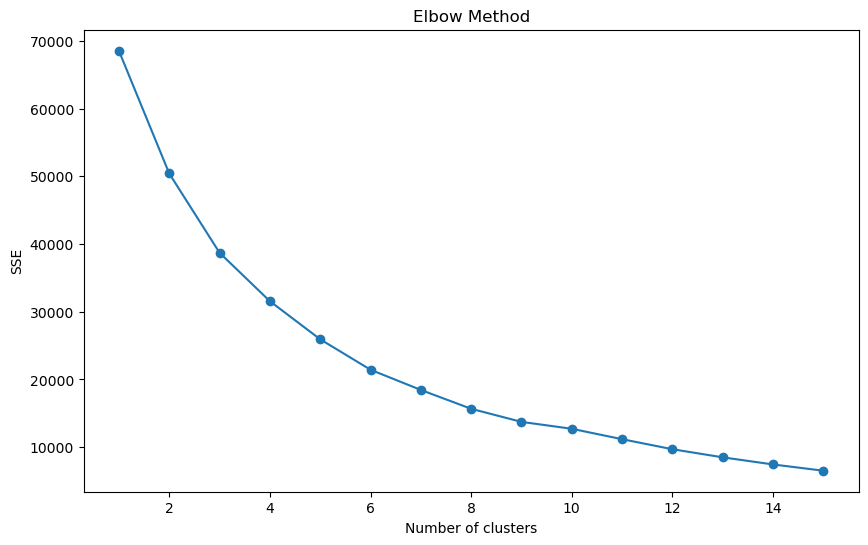

In [41]:
data = df_filtered
sse = []
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

## K-Means

Cluster 0: 14022 elements
Cluster 1: 7907 elements
Cluster 2: 8900 elements
Cluster 3: 9357 elements
Cluster 4: 15996 elements
Cluster 5: 9542 elements


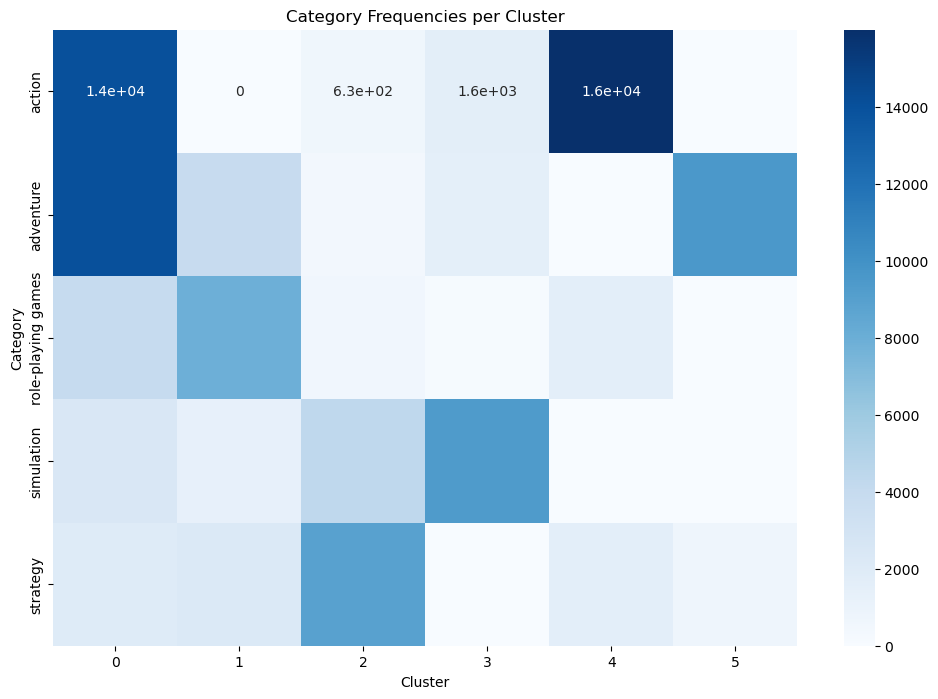

0.5540260141033447


In [42]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

data = df_filtered
k_optimal = 6
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
kmeans.fit(data)
labels = kmeans.labels_
silhouette = silhouette_score(data, labels)

# Count and print the number of points in each cluster
cluster_counts = np.bincount(labels)
for i in range(k_optimal):
    print(f'Cluster {i}: {cluster_counts[i]} elements')
    
df_clustered = df_filtered.copy()
df_clustered["cluster"] = labels

# heatmap
cluster_groups = df_clustered.groupby('cluster').sum()
cluster_groups = cluster_groups.drop(columns=['cluster'], errors='ignore')
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_groups.T, annot=True, cmap='Blues', cbar=True)
plt.title('Category Frequencies per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Category')
plt.show()

print(silhouette)


## Visualize silhouette scores for clusters
##### Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

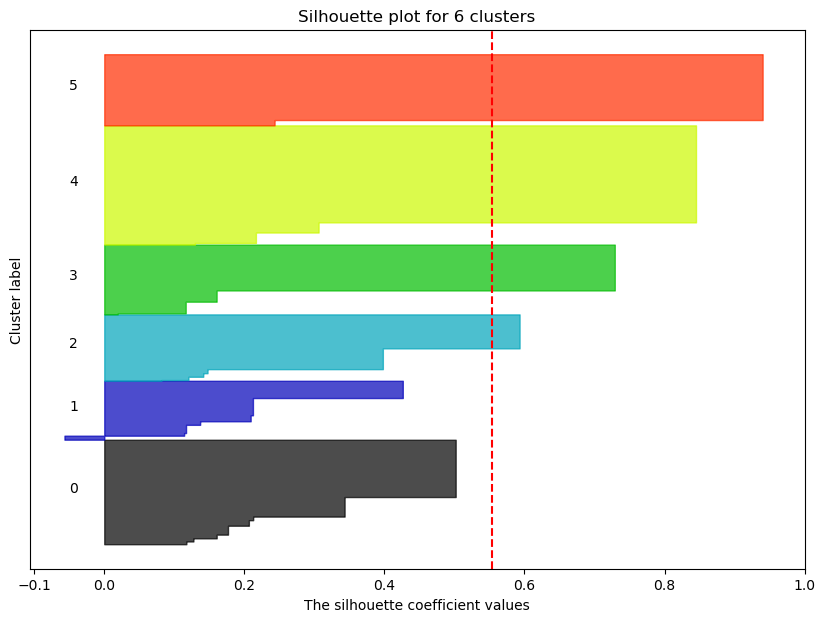

In [43]:
# Silhouette plot for the clusters
silhouette_avg = silhouette_score(data, labels)
plt.figure(figsize=(10, 7))
y_lower = 10
n_cluster = kmeans.n_clusters
cluster_labels = labels
silhouette_values = silhouette_samples(data, labels)

for i in range(n_cluster):
    ith_cluster_silhouette_values = silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_cluster)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10 

plt.title(f"Silhouette plot for {k_optimal} clusters")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])  
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

## Insert df with cluster label and AppID in mongodb

In [44]:
df_clustered["AppID"] = app_ids

In [47]:
# Convert dataframe to dictionary format
data_dict = df_clustered.to_dict('records')

# Create new collection and insert data
collection = db['Games_final']
collection.insert_many(data_dict)

print("Data uploaded successfully!")

Data uploaded successfully!


## Save the model

In [48]:
model_filename = f'model_kmeans_{silhouette:.4f}.joblib'
joblib.dump(kmeans, model_filename)
print(f'Model saved as {model_filename}')

Model saved as model_kmeans_0.5540.joblib
